# Healthy and Bleached Corals Image Classification

## Install dependencies

In [1]:
!pip install numpy pillow scikit-learn seaborn

## Imports

In [2]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

## Dataset Overview

Bleached Corals - Total Images: 484
Healthy Corals - Total Images: 438
Bleached Corals - Average Width: 301.3347107438017, Average Height: 224.98760330578511
Bleached Corals - Minimum Width: 199, Maximum Width: 1024
Bleached Corals - Minimum Height: 134, Maximum Height: 1024
Healthy Corals - Average Width: 288.51826484018267, Average Height: 237.96118721461187
Healthy Corals - Minimum Width: 150, Maximum Width: 1024
Healthy Corals - Minimum Height: 169, Maximum Height: 768


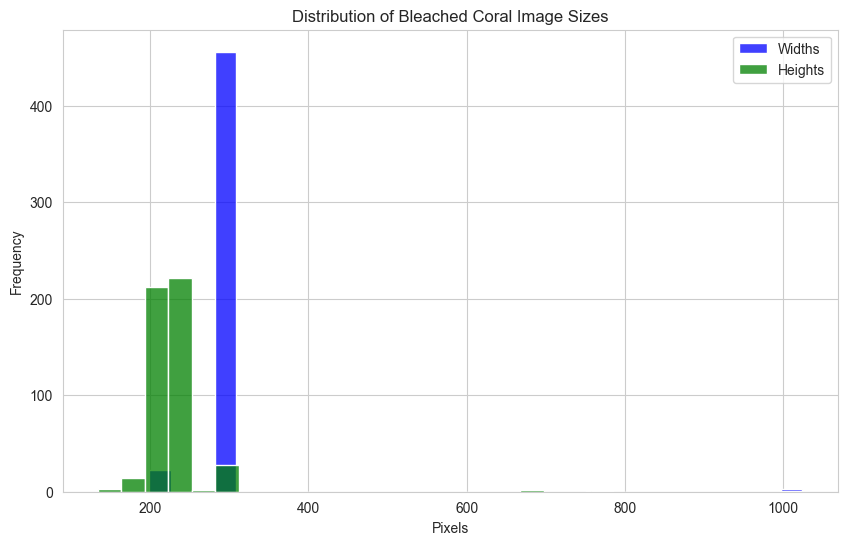

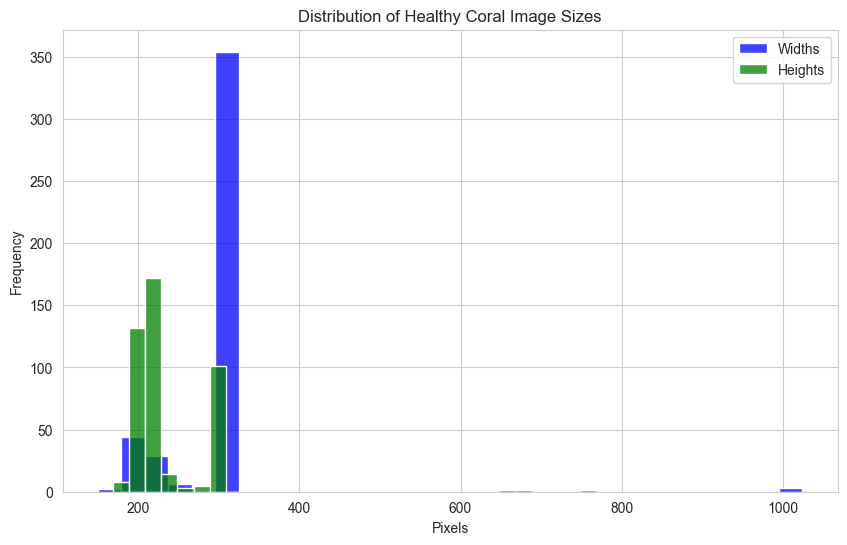

In [3]:
bleached_path = "./data/bleached_corals"
healthy_path = "./data/healthy_corals"

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Get all image paths
bleached_image_paths = get_image_paths(bleached_path)
print(f"Bleached Corals - Total Images: {len(bleached_image_paths)}")
healthy_image_paths = get_image_paths(healthy_path)
print(f"Healthy Corals - Total Images: {len(healthy_image_paths)}")

def analyze_images(image_paths):
    dimensions = []
    for img_path in image_paths:
        with Image.open(img_path) as img:
            dimensions.append(img.size) 
    
    dimensions = np.array(dimensions)
    
    avg_width = np.mean(dimensions[:, 0])
    min_width = np.min(dimensions[:, 0])
    max_width = np.max(dimensions[:, 0])
    avg_height = np.mean(dimensions[:, 1])
    min_height = np.min(dimensions[:, 1])
    max_height = np.max(dimensions[:, 1])
    
    return avg_width, min_width, max_width, avg_height, min_height, max_height, dimensions

bleached_avg_width, bleached_min_width, bleached_max_width, bleached_avg_height, bleached_min_height, bleached_max_height, bleached_dimensions = analyze_images(bleached_image_paths)
print(f"Bleached Corals - Average Width: {bleached_avg_width}, Average Height: {bleached_avg_height}")
print(f"Bleached Corals - Minimum Width: {bleached_min_width}, Maximum Width: {bleached_max_width}")
print(f"Bleached Corals - Minimum Height: {bleached_min_height}, Maximum Height: {bleached_max_height}")

healthy_avg_width, healthy_min_width, healthy_max_width, healthy_avg_height, healthy_min_height, healthy_max_height, healthy_dimensions = analyze_images(healthy_image_paths)
print(f"Healthy Corals - Average Width: {healthy_avg_width}, Average Height: {healthy_avg_height}")
print(f"Healthy Corals - Minimum Width: {healthy_min_width}, Maximum Width: {healthy_max_width}")
print(f"Healthy Corals - Minimum Height: {healthy_min_height}, Maximum Height: {healthy_max_height}")


def display_image_size_distribution(dimensions, title):
    widths = dimensions[:, 0]
    heights = dimensions[:, 1]
    plt.figure(figsize=(10, 6))
    sns.histplot(widths, color='blue', label='Widths', bins=30)
    sns.histplot(heights, color='green', label='Heights', bins=30)
    plt.title(title)
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

display_image_size_distribution(bleached_dimensions, "Distribution of Bleached Coral Image Sizes")
display_image_size_distribution(healthy_dimensions, "Distribution of Healthy Coral Image Sizes")

## Load and Resize Images

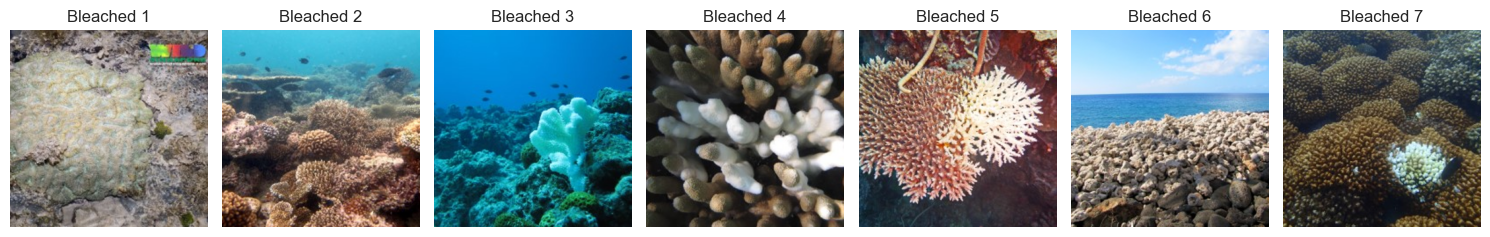

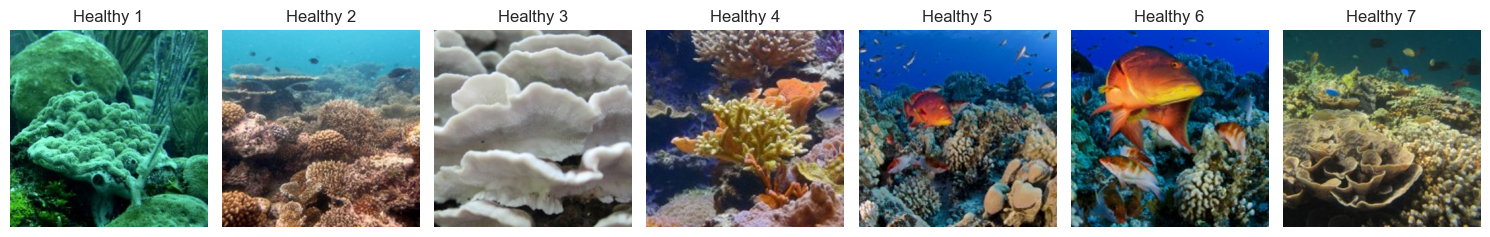

In [4]:
scale_width = 300
scale_height = 300

def load_and_resize_images(image_paths, size=(300, 300)):
    images = []
    target_size = size[0]
    
    for img_path in image_paths:
        with Image.open(img_path) as img:
            original_width, original_height = img.size
            
            aspect_ratio = original_width / original_height
            if aspect_ratio > 1:
                new_height = target_size
                new_width = int(aspect_ratio * target_size)
            else:
                new_width = target_size
                new_height = int(target_size / aspect_ratio)
                
            img = img.resize((new_width, new_height))

            x_max = new_width - target_size
            y_max = new_height - target_size

            x_offset = random.randint(0, x_max) if x_max > 0 else 0
            y_offset = random.randint(0, y_max) if y_max > 0 else 0
            
            img = img.crop((x_offset, y_offset, x_offset + target_size, y_offset + target_size))

            images.append(np.array(img).flatten())
    
    return np.array(images)

bleached_images = load_and_resize_images(bleached_image_paths)
healthy_images = load_and_resize_images(healthy_image_paths)

def head_images(image_series, width, height, title='Image', n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    
    for i in range(n):
        image = image_series[i]
        
        if len(image) == width * height * 3:
            reshaped_image = image.reshape((height, width, 3))  # RGB
        elif len(image) == width * height:
            reshaped_image = image.reshape((height, width))  # Grayscale
        else:
            raise ValueError(f"Unexpected size for image array: {len(image)}. Expected {height*width} for grayscale or {height*width*3} for RGB.")
        
        axes[i].imshow(reshaped_image, cmap='gray' if len(reshaped_image.shape) == 2 else None)
        axes[i].axis('off')
        axes[i].set_title(f'{title} {i + 1}')
    
    plt.tight_layout()
    plt.show()

head_images(bleached_images, 300, 300, 'Bleached', n=7)
head_images(healthy_images, 300, 300, 'Healthy', n=7)

# TODO: Test different filters on the images

## Labeling the dataset

In [5]:
bleached_labels = ['bleached'] * len(bleached_images)
healthy_labels = ['healthy'] * len(healthy_images)

data = np.vstack((bleached_images, healthy_images))
labels = np.array(bleached_labels + healthy_labels)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

## Split in training and testing data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.3, random_state=42)

## Train a classifier

In [7]:
classifier = RandomForestClassifier(n_estimators=20, random_state=42)
# classifier = KNeighborsClassifier(n_neighbors=10)
# classifier = DecisionTreeClassifier(max_depth=20)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.6895306859205776
Classification Report:
              precision    recall  f1-score   support

    bleached       0.71      0.75      0.73       154
     healthy       0.66      0.61      0.64       123

    accuracy                           0.69       277
   macro avg       0.69      0.68      0.68       277
weighted avg       0.69      0.69      0.69       277



## Confusion Matrix

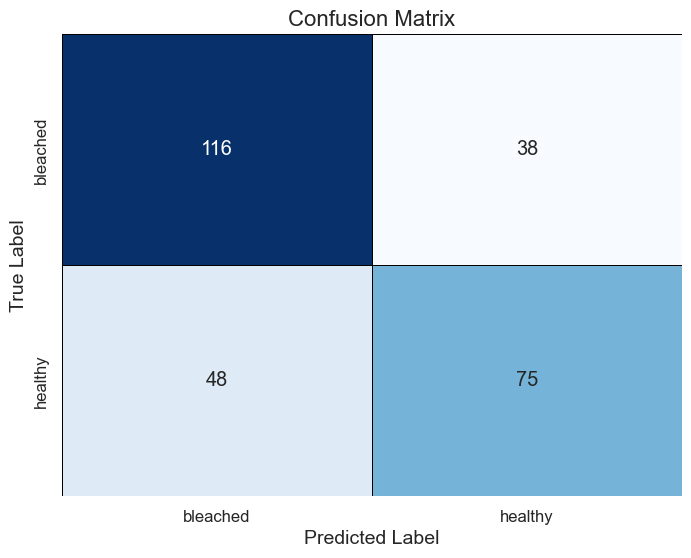

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5, linecolor='black')

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.xticks([0.5, 1.5], label_encoder.classes_, fontsize=12)
plt.yticks([0.5, 1.5], label_encoder.classes_, fontsize=12)

plt.show()